# Classifiers 

In [33]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

## Features selection for SVM & K-NN

In [28]:
# Load CSV
df = pd.read_csv("all_features.csv")

In [29]:
df.columns

Index(['patient_id', 'epoch_id', 'EEG mean', 'EEG median', 'EEG variance',
       'EEG std', 'EEG skewness', 'EEG kurtosis', 'EEG zero_crossings',
       'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG hjorth_complexity',
       'EEG spectral_entropy', 'EEG spectral_edge_50', 'EEG spectral_edge_95',
       'EEG absolute_power slow_delta', 'EEG absolute_power delta',
       'EEG absolute_power theta', 'EEG absolute_power alpha',
       'EEG absolute_power beta', 'EEG absolute_power gamma',
       'EEG relative_power slow_delta', 'EEG relative_power delta',
       'EEG relative_power theta', 'EEG relative_power alpha',
       'EEG relative_power beta', 'EEG relative_power gamma',
       'EEG power_ratios slow_delta_to_delta',
       'EEG power_ratios delta_to_theta', 'EEG power_ratios theta_to_alpha',
       'EEG power_ratios alpha_to_beta', 'EEG power_ratios delta_to_beta',
       'EEG power_ratios theta_to_beta',
       'EEG power_ratios slow_delta_to_gamma',
       'EEG power_ratio

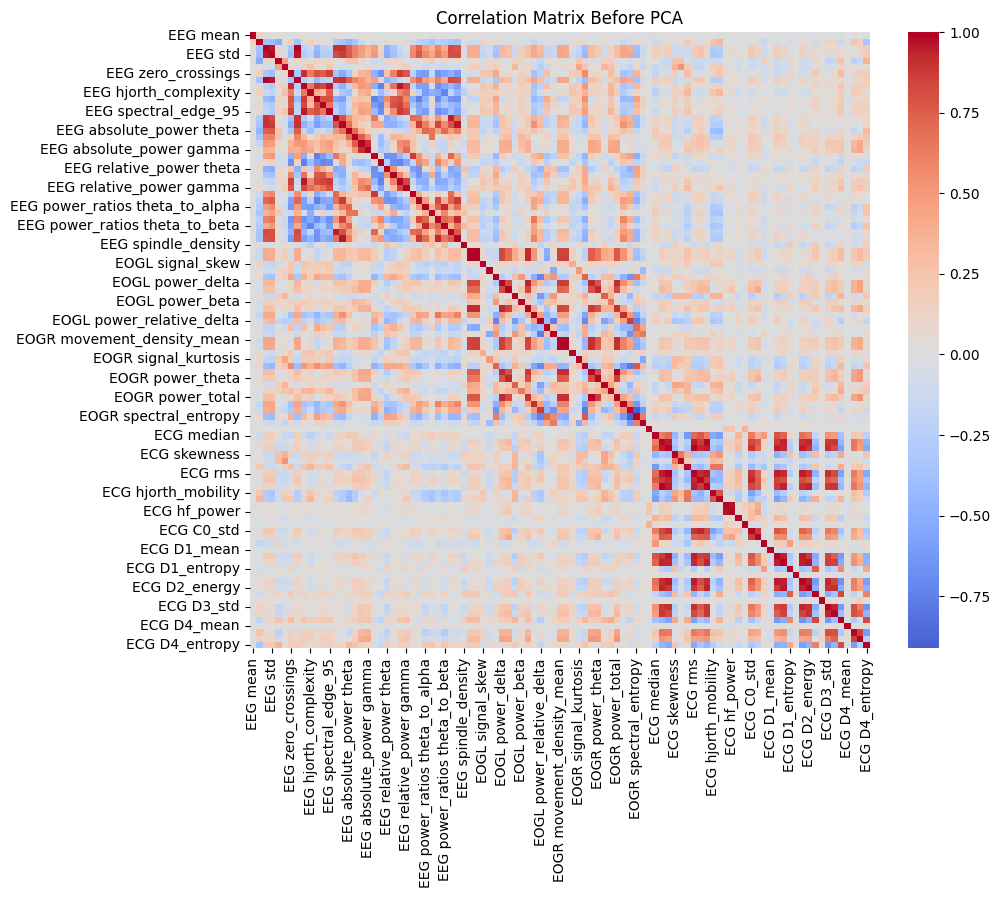


Highly correlated feature pairs (|corr| > 0.95):
EEG std & EEG variance => correlation = 0.960
EEG hjorth_activity & EEG variance => correlation = 1.000
EEG hjorth_activity & EEG std => correlation = 0.960
EEG relative_power beta & EEG hjorth_mobility => correlation = 0.956
EEG power_ratios delta_to_gamma & EEG absolute_power delta => correlation = 0.956
EOGL signal_std & EOGL movement_density_mean => correlation = 0.991
EOGR signal_std & EOGR movement_density_mean => correlation = 0.989
EOGR power_total & EOGR power_delta => correlation = 0.994
ECG std & ECG variance => correlation = 0.952
ECG rms & ECG variance => correlation = 0.952
ECG rms & ECG std => correlation = 1.000
ECG hjorth_activity & ECG variance => correlation = 1.000
ECG hjorth_activity & ECG std => correlation = 0.952
ECG hjorth_activity & ECG rms => correlation = 0.952
ECG hf_power & ECG lf_power => correlation = 0.966
ECG D2_std & ECG std => correlation = 0.951
ECG D2_std & ECG rms => correlation = 0.951
ECG D2_std 

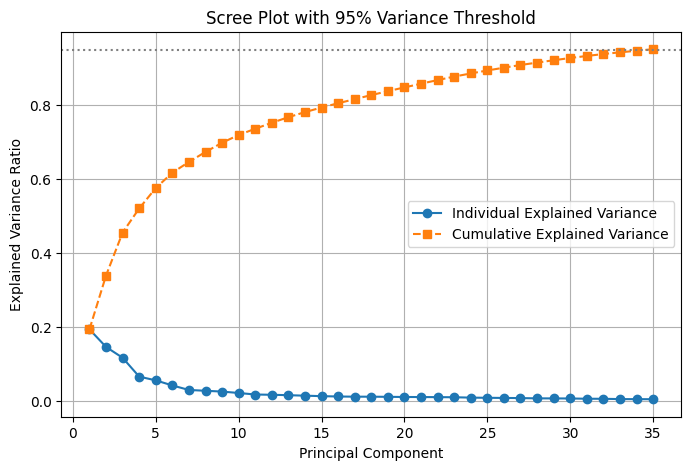

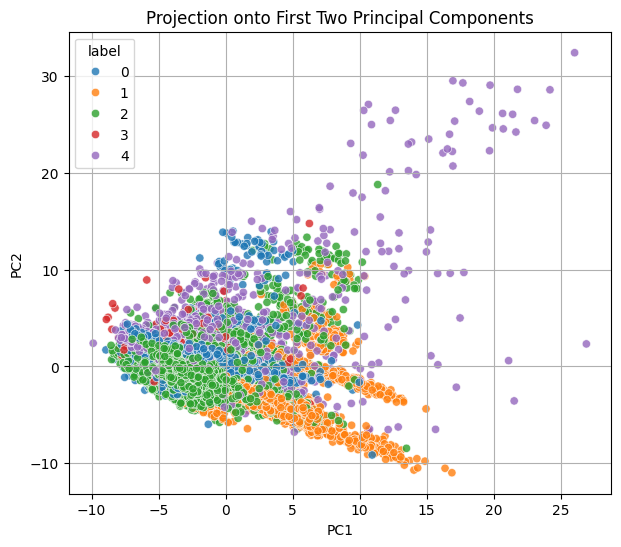

In [30]:
# 1. Separate identifier and label columns
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

# Keep non-feature columns aside
ids = df[id_cols]
labels = df[label_col]
features = df.drop(columns=id_cols + [label_col])

# 2. Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_df = pd.DataFrame(features_scaled, columns=features.columns)

# 3. Plot correlation heatmap before PCA
corr_matrix = features_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Matrix Before PCA")
plt.show()

# 4. Identify highly correlated feature pairs (above 0.95)
threshold = 0.95
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            f1 = corr_matrix.columns[i]
            f2 = corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            high_corr_pairs.append((f1, f2, corr_val))

# Print highly correlated feature pairs
print("\nHighly correlated feature pairs (|corr| > 0.95):")
for f1, f2, val in high_corr_pairs:
    print(f"{f1} & {f2} => correlation = {val:.3f}")

# Features to remove based on high correlation
features_to_remove = set([f for pair in high_corr_pairs for f in pair[:2]])
features_remaining = [f for f in features.columns if f not in features_to_remove]
print(f"\n{len(features_to_remove)} features involved in high correlation and would typically be removed:")
print(sorted(features_to_remove))
print(f"\n{len(features_remaining)} features are not highly correlated and would remain if manually filtering:")
print(sorted(features_remaining))

# 5. Apply PCA (retain 95% of variance)
pca = PCA(n_components=0.95)
features_pca = pca.fit_transform(features_scaled)

# 5a. Explained variance and why these components were selected
explained_ratios = pca.explained_variance_ratio_
cumulative_ratios = explained_ratios.cumsum()
selected_n = pca.n_components_

print(f"\nPCA retained {selected_n} components to preserve 95% of the variance.")
print("Individual explained variance ratios for retained components:")
for i, (ratio, cum_ratio) in enumerate(zip(explained_ratios, cumulative_ratios), start=1):
    print(f"  PC{i}: {ratio:.4f} (cumulative: {cum_ratio:.4f})")

print("\nComponents are selected because the cumulative explained variance reaches the 95% threshold at the last listed PC.")

# 6. Scree plot with threshold line
plt.figure(figsize=(8, 5))
components = range(1, len(explained_ratios) + 1)
plt.plot(components, explained_ratios, 'o-', label='Individual Explained Variance')
plt.plot(components, cumulative_ratios, 's--', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='gray', linestyle=':')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot with 95% Variance Threshold')
plt.legend()
plt.grid(True)
plt.show()

# 7. Combine PCA result into final DataFrame
df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])
df_final = pd.concat([ids.reset_index(drop=True), labels.reset_index(drop=True), df_pca], axis=1)

# 8. Scatter plot of PC1 vs PC2
plt.figure(figsize=(7, 6))
sns.scatterplot(data=df_final, x='PC1', y='PC2', hue=label_col, palette='tab10', alpha=0.8)
plt.title('Projection onto First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.legend(title=label_col)
plt.show()


In [31]:
df_final

,patient_id,epoch_id,label,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,1,0,3,-5.886218,8.936737,9.289244,4.888662,5.699874,-4.095372,-2.437159,...,0.983267,-0.388575,2.689495,0.656195,0.950485,-2.637461,-2.011833,-3.614236,0.013132,-0.595992
1,1,1,2,-4.918202,2.951465,1.045957,1.387439,0.161203,0.015680,-2.468481,...,-0.049749,0.384379,0.620728,0.167143,-0.634682,0.218103,1.748385,0.042195,-0.282001,0.387825
2,1,2,2,-1.985364,-0.275283,-0.193149,1.300297,-2.367856,0.076978,-0.123773,...,1.111017,-0.076229,-0.794872,0.732428,1.177029,0.097132,1.555758,-0.245932,0.351938,0.676107
3,1,3,2,0.070489,-1.771522,-0.238112,0.950212,-1.895329,1.063230,-0.050421,...,0.611488,1.224177,-0.954801,-0.463562,0.023661,-0.166703,0.861404,-0.488722,0.350324,0.567362
4,1,4,4,1.685933,-2.529613,0.964104,0.210730,-1.078292,-0.407396,1.232070,...,-1.218056,0.996019,-0.714466,0.291143,0.293655,-0.751351,0.645246,-0.523683,0.780050,0.864558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8009,10,965,2,0.481452,-1.523561,-0.744184,0.593489,0.590926,-1.019722,1.603275,...,-0.623317,0.487592,-0.110642,-0.299787,-0.035997,0.018950,0.225698,-0.487889,0.494537,0.190145
8010,10,966,2,-4.587594,1.845426,-1.528166,2.322723,-0.474462,-0.475935,-1.516066,...,-0.763750,-0.517370,-0.166268,-0.208846,0.010921,-0.590963,0.132442,0.347244,0.304098,0.282962
8011,10,967,2,-2.055768,0.883620,-0.099047,0.888539,1.841223,-0.794089,1.602472,...,1.085496,-1.253056,0.569448,1.910610,1.243593,0.455293,-0.087522,0.257285,1.638110,0.448546
8012,10,968,2,0.037984,-1.396743,-0.184920,0.158754,2.584458,-1.799386,1.930229,...,0.981499,-1.877276,-0.164620,0.348236,-0.631667,-0.215107,-0.600668,-0.653596,0.637358,0.085949


## Different classifiers 

## K-NN

=== K-NN Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.70      0.75       222
           1       0.76      0.78      0.77       324
           2       0.75      0.87      0.81       759
           3       0.31      0.15      0.21        52
           4       0.78      0.57      0.66       246

    accuracy                           0.76      1603
   macro avg       0.68      0.61      0.64      1603
weighted avg       0.75      0.76      0.75      1603



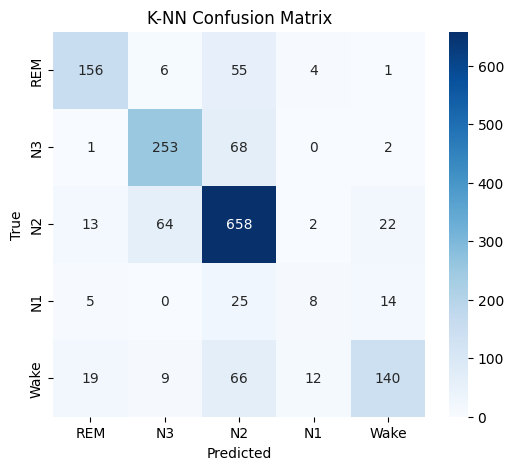

=== SVM Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.65      0.75       222
           1       0.79      0.79      0.79       324
           2       0.75      0.87      0.81       759
           3       0.00      0.00      0.00        52
           4       0.75      0.70      0.73       246

    accuracy                           0.77      1603
   macro avg       0.63      0.60      0.61      1603
weighted avg       0.75      0.77      0.76      1603



c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


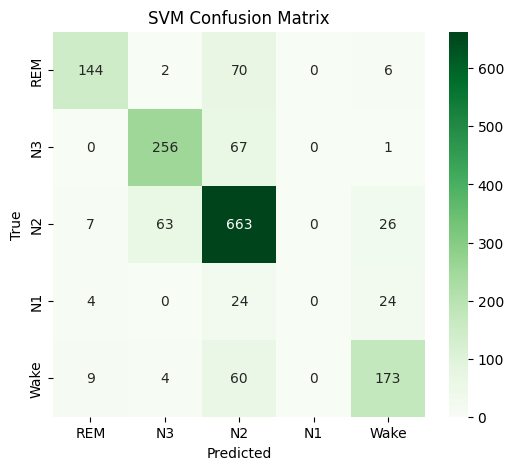

K-NN -> Precision: 0.753, Recall: 0.758, F1: 0.750
SVM  -> Precision: 0.751, Recall: 0.771, F1: 0.756


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


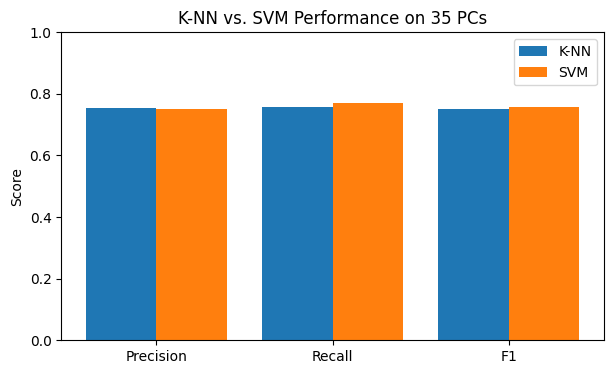

In [53]:
# Assume df_final contains 'label' and PCs named PC1...PC35
# Prepare features and labels
X = df_final[[f'PC{i+1}' for i in range(df_pca.shape[1])]]
y = df_final['label']

# Split into train/test
time_seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=time_seed
)

# 1) K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Metrics
print("=== K-NN Classification Report ===")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
label_names = ["REM", "N3", "N2", "N1", "Wake"]
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6,5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('K-NN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 2) Support Vector Machine (RBF kernel)
svc = SVC(kernel='rbf', C=1.0, gamma='scale')
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

# Metrics
print("=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svc))

# Confusion Matrix
label_names = ["REM", "N3", "N2", "N1", "Wake"]
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6,5))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Greens', xticklabels=label_names, yticklabels=label_names)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# After predicting:
y_pred_knn = knn.predict(X_test)
y_pred_svc = svc.predict(X_test)

# Compute weighted scores
prec_knn = precision_score(y_test, y_pred_knn, average='weighted')
rec_knn  = recall_score(   y_test, y_pred_knn, average='weighted')
f1_knn   = f1_score(       y_test, y_pred_knn, average='weighted')

prec_svc = precision_score(y_test, y_pred_svc, average='weighted')
rec_svc  = recall_score(   y_test, y_pred_svc, average='weighted')
f1_svc   = f1_score(       y_test, y_pred_svc, average='weighted')

print(f"K-NN -> Precision: {prec_knn:.3f}, Recall: {rec_knn:.3f}, F1: {f1_knn:.3f}")
print(f"SVM  -> Precision: {prec_svc:.3f}, Recall: {rec_svc:.3f}, F1: {f1_svc:.3f}")

# Bar chart comparison
metrics     = ['Precision', 'Recall', 'F1']
knn_scores  = [prec_knn, rec_knn, f1_knn]
svc_scores  = [prec_svc, rec_svc, f1_svc]
x           = np.arange(len(metrics))

plt.figure(figsize=(7, 4))
plt.bar(x - 0.2, knn_scores, width=0.4, label='K-NN')
plt.bar(x + 0.2, svc_scores, width=0.4, label='SVM')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('K-NN vs. SVM Performance on 35 PCs')
plt.legend()
plt.show()


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


        KNN                           SVM                         Delta  \
  precision    recall  f1-score precision    recall  f1-score precision   
0  0.804124  0.702703  0.750000  0.878049  0.648649  0.746114  0.073925   
1  0.762048  0.780864  0.771341  0.787692  0.790123  0.788906  0.025644   
2  0.754587  0.866930  0.806867  0.750000  0.873518  0.807060 -0.004587   
3  0.307692  0.153846  0.205128  0.000000  0.000000  0.000000 -0.307692   
4  0.782123  0.569106  0.658824  0.752174  0.703252  0.726891 -0.029949   

                       
     recall  f1-score  
0 -0.054054 -0.003886  
1  0.009259  0.017565  
2  0.006588  0.000193  
3 -0.153846 -0.205128  
4  0.134146  0.068067  


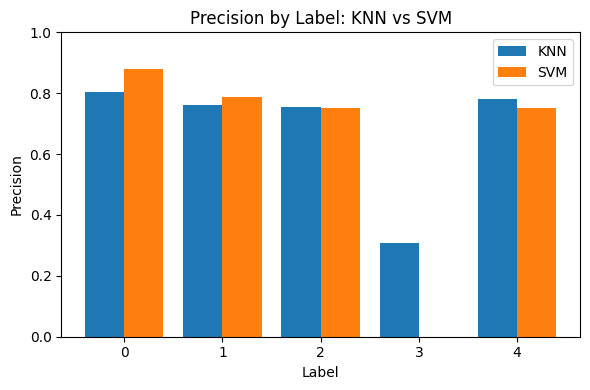

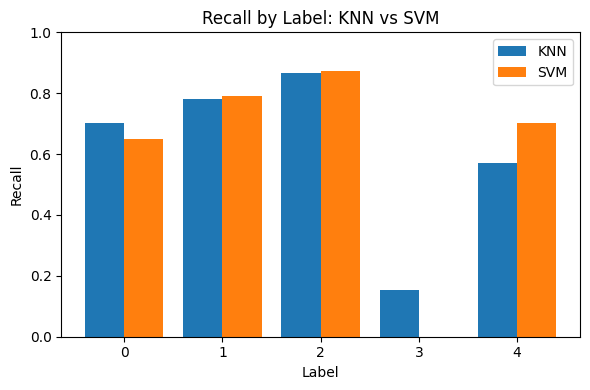

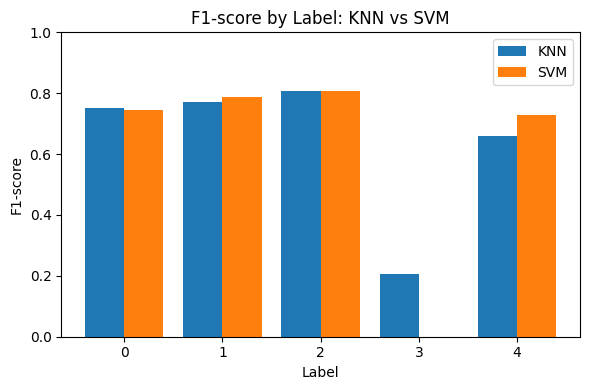

In [38]:
# 1) Get per-class reports as dicts (only labels 0–4)
report_knn = classification_report(
    y_test, y_pred_knn,
    labels=[0,1,2,3,4],
    output_dict=True
)
report_svc = classification_report(
    y_test, y_pred_svc,
    labels=[0,1,2,3,4],
    output_dict=True
)

# 2) Build DataFrames for those labels
labels = ['0','1','2','3','4']
df_knn = pd.DataFrame(report_knn).T.loc[labels, ['precision','recall','f1-score']]
df_svc = pd.DataFrame(report_svc).T.loc[labels, ['precision','recall','f1-score']]

# 3) Add model identifiers to columns
df_knn.columns = pd.MultiIndex.from_product([['KNN'], df_knn.columns])
df_svc.columns = pd.MultiIndex.from_product([['SVM'], df_svc.columns])

# 4) Concatenate side by side and compute deltas
df_compare = pd.concat([df_knn, df_svc], axis=1)
df_compare[('Delta','precision')] = df_compare[('SVM','precision')] - df_compare[('KNN','precision')]
df_compare[('Delta','recall')]    = df_compare[('SVM','recall')]    - df_compare[('KNN','recall')]
df_compare[('Delta','f1-score')]  = df_compare[('SVM','f1-score')]  - df_compare[('KNN','f1-score')]

print(df_compare)

# 5) Optional: bar plots for each metric
metrics = ['precision','recall','f1-score']
x = np.arange(len(labels))

for metric in metrics:
    plt.figure(figsize=(6,4))
    plt.bar(x-0.2, df_compare[('KNN', metric)], width=0.4, label='KNN')
    plt.bar(x+0.2, df_compare[('SVM', metric)], width=0.4, label='SVM')
    plt.xticks(x, labels)
    plt.ylim(0,1)
    plt.xlabel('Label')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} by Label: KNN vs SVM')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Random Forest

Dropping 23 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power delta', 'EEG relative_power beta', 'EEG power_ratios delta_to_gamma', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total', 'ECG variance', 'ECG std', 'ECG rms', 'ECG hjorth_activity', 'ECG lf_power', 'ECG hf_power', 'ECG D1_std', 'ECG D1_energy', 'ECG D2_std', 'ECG D2_energy']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       222
           1       0.85      0.78      0.82       324
           2       0.78      0.91      0.84       759
           3       0.75      0.06      0.11        52
           4       0.76      0.72      0.74       246

    accuracy                           0.80      1603
   macro avg       0.81      0.64      0.66      1603
weighted avg       0.81      0.80    

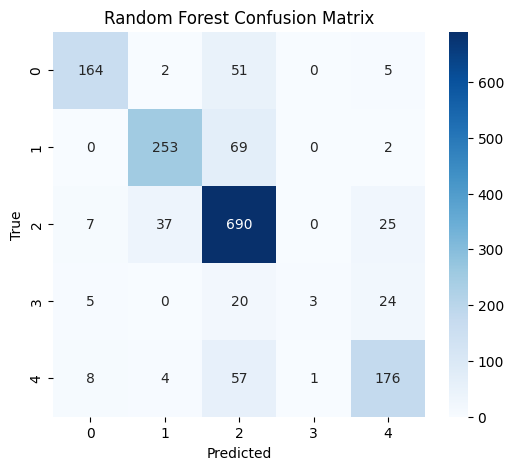

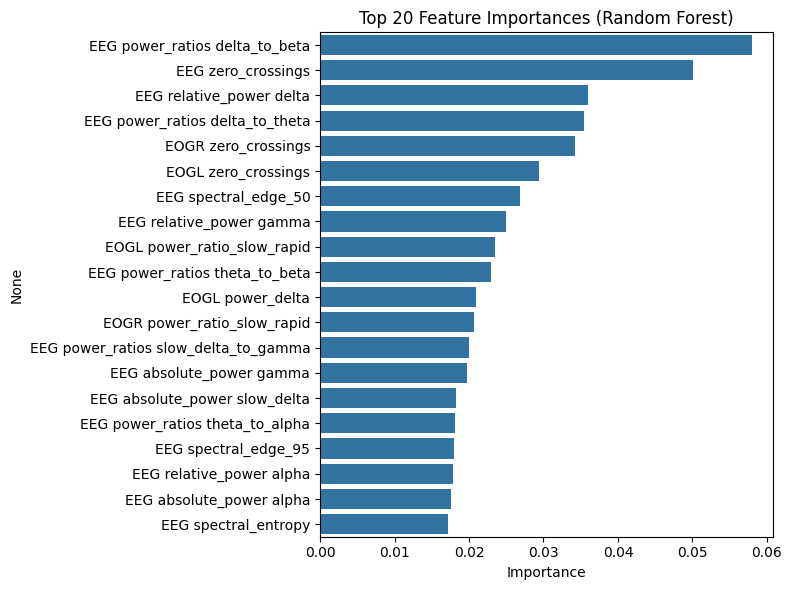

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# --- 1) Prepare data ---
# Assume `df` has columns: ['patient_id','epoch_id','label', ... feature columns ...]
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

# Separate out IDs and target
ids    = df[id_cols]
y      = df[label_col]
X_full = df.drop(columns=id_cols + [label_col])

# --- 2) Drop highly correlated features ---
def drop_high_corr(X, threshold=0.95):
    corr = X.corr().abs()
    np.fill_diagonal(corr.values, 0)
    to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
    print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
    print(to_drop)
    return X.drop(columns=to_drop)

X_uncorr = drop_high_corr(X_full, threshold=0.95)

# --- 3) (Optional) Embedded selection via RF importance ---
# You can further trim to the top-N features if you like. For example:
# rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_temp.fit(X_uncorr, y)
# sel = SelectFromModel(rf_temp, threshold='median', prefit=True)
# X_sel = sel.transform(X_uncorr)
# print(f"Reduced to {X_sel.shape[1]} features after importance filtering.")
# # And reset X_uncorr = pd.DataFrame(X_sel, columns=X_uncorr.columns[sel.get_support()])

# For now we'll just proceed with X_uncorr:
X_processed = X_uncorr

# --- 4) Split into train / test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# --- 5) Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# --- 6) Evaluate ---
y_pred_rf = rf.predict(X_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --- 7) Feature importances ---
importances = pd.Series(rf.feature_importances_, index=X_processed.columns)
importances = importances.sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=importances.values, y=importances.index, orient='h')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


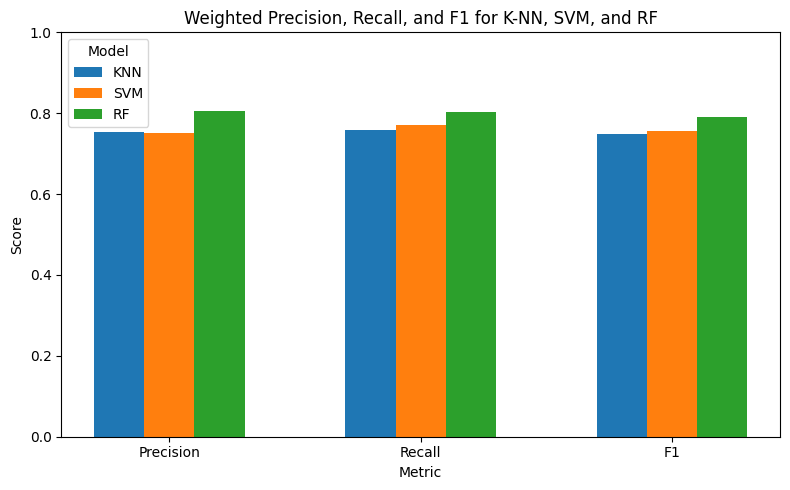

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you already have:
# y_test, y_pred_knn, y_pred_svc, y_pred_rf

# 1) Compute weighted metrics for each model
model_preds = {
    'KNN': y_pred_knn,
    'SVM': y_pred_svc,
    'RF':  y_pred_rf,
}

metrics = ['precision', 'recall', 'f1']
results = {}
for name, preds in model_preds.items():
    results[name] = [
        precision_score(y_test, preds, average='weighted'),
        recall_score(   y_test, preds, average='weighted'),
        f1_score(       y_test, preds, average='weighted'),
    ]

# 2) Prepare for plotting
labels = [m.capitalize() for m in metrics]
x = np.arange(len(labels))
width = 0.2  # width of each bar

# 3) Create grouped bar chart
plt.figure(figsize=(8, 5))
for i, (model, scores) in enumerate(results.items()):
    plt.bar(x + (i - 1)*width, scores, width, label=model)

# 4) Labels and legend
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, and F1 for K-NN, SVM, and RF')
plt.legend(title='Model')
plt.tight_layout()
plt.show()



### XG-boost

Dropping 23 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power delta', 'EEG relative_power beta', 'EEG power_ratios delta_to_gamma', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total', 'ECG variance', 'ECG std', 'ECG rms', 'ECG hjorth_activity', 'ECG lf_power', 'ECG hf_power', 'ECG D1_std', 'ECG D1_energy', 'ECG D2_std', 'ECG D2_energy']


c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:21:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:21:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Selected 37 features by embedded importance:
['EEG kurtosis', 'EEG zero_crossings', 'EEG hjorth_complexity', 'EEG spectral_edge_50', 'EEG spectral_edge_95', 'EEG absolute_power slow_delta', 'EEG absolute_power theta', 'EEG absolute_power alpha', 'EEG absolute_power beta', 'EEG absolute_power gamma', 'EEG relative_power delta', 'EEG relative_power theta', 'EEG relative_power alpha', 'EEG power_ratios slow_delta_to_delta', 'EEG power_ratios delta_to_theta', 'EEG power_ratios theta_to_alpha', 'EEG power_ratios alpha_to_beta', 'EEG power_ratios delta_to_beta', 'EEG power_ratios theta_to_beta', 'EOGL zero_crossings', 'EOGL power_delta', 'EOGL power_theta', 'EOGL power_alpha', 'EOGL power_total', 'EOGL power_ratio_slow_rapid', 'EOGL power_relative_delta', 'EOGR signal_skew', 'EOGR zero_crossings', 'EOGR power_alpha', 'EOGR power_beta', 'EOGR power_ratio_slow_rapid', 'ECG skewness', 'ECG hjorth_mobility', 'ECG hjorth_complexity', 'ECG C0_std', 'ECG D4_std', 'ECG D4_entropy']

=== XGBoost Cla

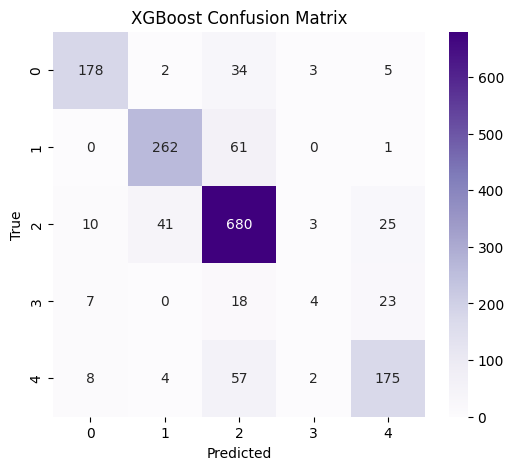

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model   Prec.    Rec.      F1
--------------------------
KNN     0.753   0.758   0.750
SVM     0.751   0.771   0.756
RF      0.805   0.802   0.790
XGB     0.800   0.810   0.801


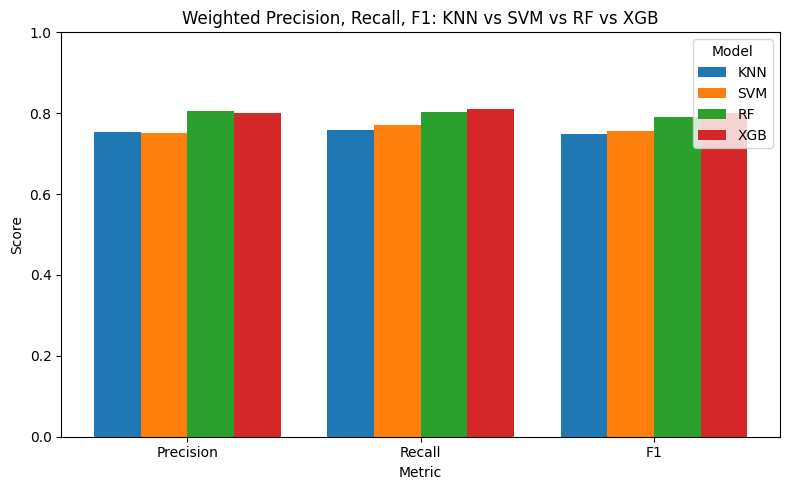

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from xgboost import XGBClassifier

# --- 1) Prepare data ---
# Assume df has ['patient_id','epoch_id','label', ...features...]
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

X_full = df.drop(columns=id_cols + [label_col])
y      = df[label_col]

# --- 2) Drop highly correlated features ---
def drop_high_corr(X, threshold=0.95):
    corr = X.corr().abs()
    np.fill_diagonal(corr.values, 0)
    to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
    print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
    print(to_drop)
    return X.drop(columns=to_drop)

X_uncorr = drop_high_corr(X_full, threshold=0.95)

# --- 3) Train‐time split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_uncorr, y, test_size=0.2, stratify=y, random_state=42
)

# --- 4) Embedded feature selection with XGBoost ---
# 4a) Fit a preliminary XGB to get importances
temp_xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
temp_xgb.fit(X_train, y_train)

# 4b) Select features above median importance
selector = SelectFromModel(temp_xgb, threshold='median', prefit=True)
X_train_sel = selector.transform(X_train)
X_test_sel  = selector.transform(X_test)

selected_features = X_uncorr.columns[selector.get_support()]
print(f"\nSelected {len(selected_features)} features by embedded importance:")
print(list(selected_features))

# --- 5) Final XGBoost classifier on selected features ---
xgb_clf = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_sel, y_train)
y_pred_xgb = xgb_clf.predict(X_test_sel)

# --- 6) Evaluation ---
print("\n=== XGBoost Classification Report ===")
print(classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --- 7) Compare weighted scores with K-NN, SVM, RF ---
# Assume y_pred_knn, y_pred_svc, y_pred_rf exist
models = {
    'KNN': y_pred_knn,
    'SVM': y_pred_svc,
    'RF':  y_pred_rf,
    'XGB': y_pred_xgb
}

metrics = ['precision', 'recall', 'f1']
results = {m: [
    precision_score(y_test, preds, average='weighted'),
    recall_score(   y_test, preds, average='weighted'),
    f1_score(       y_test, preds, average='weighted')
] for m, preds in models.items()}

# Print table
print(f"{'Model':<5}  {'Prec.':>6}  {'Rec.':>6}  {'F1':>6}")
print("-"*26)
for m, scores in results.items():
    print(f"{m:<5}  {scores[0]:6.3f}  {scores[1]:6.3f}  {scores[2]:6.3f}")

# --- 8) Bar chart comparison ---
x = np.arange(len(metrics))
width = 0.2

plt.figure(figsize=(8,5))
for i, (m, scores) in enumerate(results.items()):
    plt.bar(x + (i-1.5)*width, scores, width, label=m)

plt.xticks(x, [m.capitalize() for m in metrics])
plt.ylim(0,1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, F1: KNN vs SVM vs RF vs XGB')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


## Deep learning

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- 1) Prepare data ---
# Assume df defined with ['patient_id', 'epoch_id', 'label', ...features...]
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'
X_full = df.drop(columns=id_cols + [label_col])
y = df[label_col]

# --- 2) Drop highly correlated features ---
def drop_high_corr(X, threshold=0.95):
    corr = X.corr().abs()
    np.fill_diagonal(corr.values, 0)
    to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
    print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
    print(to_drop)
    return X.drop(columns=to_drop)

X_uncorr = drop_high_corr(X_full, threshold=0.95)

# --- 3) Feature selection: univariate ---
k = min(20, X_uncorr.shape[1])
selector = SelectKBest(score_func=f_classif, k=k)
X_sel = selector.fit_transform(X_uncorr, y)
selected_features = X_uncorr.columns[selector.get_support()]
print(f"Selected top {k} features by ANOVA F-test:")
print(list(selected_features))

# --- 4) Train-test split and scaling ---
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.2, stratify=y, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# --- 5) Prepare PyTorch datasets ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

tensor_X_train = torch.tensor(X_train, dtype=torch.float32)
tensor_y_train = torch.tensor(y_train_enc, dtype=torch.long)
tensor_X_test  = torch.tensor(X_test, dtype=torch.float32)
tensor_y_test  = torch.tensor(y_test_enc, dtype=torch.long)

train_ds = TensorDataset(tensor_X_train, tensor_y_train)
val_size = int(0.1 * len(train_ds))
train_size = len(train_ds) - val_size
train_ds, val_ds = torch.utils.data.random_split(train_ds, [train_size, val_size])

dl_train = DataLoader(train_ds, batch_size=16, shuffle=True)
dl_val   = DataLoader(val_ds, batch_size=16)
dl_test  = DataLoader(TensorDataset(tensor_X_test, tensor_y_test), batch_size=16)

# --- 6) Define lightweight MLP ---
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)

model = SimpleMLP(input_dim=X_train.shape[1], num_classes=len(le.classes_))

# --- 7) Training setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stop = 5
best_val_loss = np.inf
patience = 0
best_model_wts = copy.deepcopy(model.state_dict())

# --- 8) Training loop (max 30 epochs) ---
for epoch in range(1, 31):
    model.train()
    train_loss = 0
    for Xb, yb in dl_train:
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(dl_train)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xv, yv in dl_val:
            val_loss += criterion(model(Xv), yv).item()
    val_loss /= len(dl_val)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        patience = 0
    else:
        patience += 1
        if patience >= early_stop:
            print("Early stopping at epoch", epoch)
            break

# load best weights
model.load_state_dict(best_model_wts)


Dropping 23 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power delta', 'EEG relative_power beta', 'EEG power_ratios delta_to_gamma', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total', 'ECG variance', 'ECG std', 'ECG rms', 'ECG hjorth_activity', 'ECG lf_power', 'ECG hf_power', 'ECG D1_std', 'ECG D1_energy', 'ECG D2_std', 'ECG D2_energy']
Selected top 20 features by ANOVA F-test:
['EEG zero_crossings', 'EEG hjorth_complexity', 'EEG spectral_entropy', 'EEG spectral_edge_50', 'EEG spectral_edge_95', 'EEG absolute_power slow_delta', 'EEG relative_power slow_delta', 'EEG relative_power delta', 'EEG relative_power theta', 'EEG relative_power alpha', 'EEG relative_power gamma', 'EEG power_ratios delta_to_theta', 'EEG power_ratios theta_to_alpha', 'EEG power_ratios delta_to_beta', 'EEG power_ratios theta_to_beta', 'EEG power_ratios slow_d

AttributeError: 'numpy.ndarray' object has no attribute 'extend'


=== Lightweight DL Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.67      0.73       222
           1       0.83      0.77      0.80       324
           2       0.74      0.88      0.80       759
           3       0.00      0.00      0.00        52
           4       0.73      0.64      0.68       246

    accuracy                           0.76      1603
   macro avg       0.62      0.59      0.60      1603
weighted avg       0.74      0.76      0.75      1603



c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


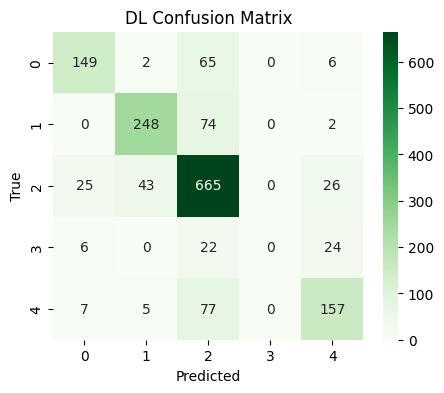

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


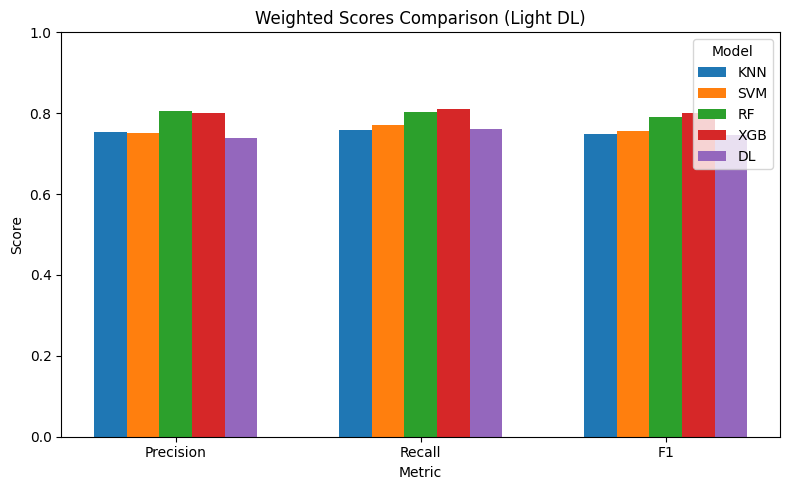

In [51]:
# --- 9) Evaluation ---
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for Xb, yb in dl_test:
        logits = model(Xb)
        pred = logits.argmax(dim=1)
        y_pred_batch = pred.cpu().tolist()
        y_true_batch = yb.cpu().tolist()
        y_pred.extend(y_pred_batch)
        y_true.extend(y_true_batch)

y_pred_lbl = le.inverse_transform(y_pred)
y_true_lbl = le.inverse_transform(y_true)

print("\n=== Lightweight DL Classification Report ===")
print(classification_report(y_true_lbl, y_pred_lbl))

cm = confusion_matrix(y_true_lbl, y_pred_lbl)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('DL Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --- 10) Compare weighted scores ---
metrics = ['precision', 'recall', 'f1']
n_metrics = len(metrics)
models = list(all_results.keys())
n_models = len(models)

# 1) Smaller bar width
bar_width = 0.12

# 2) Compute an expanded x-axis range with extra padding
x = np.arange(n_metrics) * (n_models * bar_width + 0.3)  # 0.3 adds group spacing

plt.figure(figsize=(8,5))

# 3) Plot each model offset by its index * bar_width
for i, m in enumerate(models):
    scores = [
        precision_score(y_true_lbl if m=='DL' else y_test, all_results[m], average='weighted'),
        recall_score(   y_true_lbl if m=='DL' else y_test, all_results[m], average='weighted'),
        f1_score(       y_true_lbl if m=='DL' else y_test, all_results[m], average='weighted')
    ]
    # shift = (i - n_models/2) * bar_width puts models symmetrically around each x
    shift = (i - (n_models-1)/2) * bar_width
    plt.bar(x + shift, scores, bar_width, label=m)

# Ticks in the middle of each group
group_centers = x
plt.xticks(group_centers, [m.capitalize() for m in metrics])

plt.ylim(0,1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Scores Comparison (Light DL)')
plt.legend(title='Model')
plt.tight_layout()
plt.show()